<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Creating-different-tags-from-the-training-set" data-toc-modified-id="Creating-different-tags-from-the-training-set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Creating different tags from the training set</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Scatter-plot" data-toc-modified-id="Scatter-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scatter plot</a></span></li><li><span><a href="#Details-on-each-problematic-classifications" data-toc-modified-id="Details-on-each-problematic-classifications-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Details on each problematic classifications</a></span><ul class="toc-item"><li><span><a href="#'Some'-classification" data-toc-modified-id="'Some'-classification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>'Some' classification</a></span></li><li><span><a href="#'50-50'-category" data-toc-modified-id="'50-50'-category-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>'50-50' category</a></span></li><li><span><a href="#insufficient-evidence" data-toc-modified-id="insufficient-evidence-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>insufficient evidence</a></span></li><li><span><a href="#Wrongly-classified-jobs" data-toc-modified-id="Wrongly-classified-jobs-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Wrongly classified jobs</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-wrongly-classify-as-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-Software-job-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Description of the wrongly classify as Software job</a></span></li><li><span><a href="#Description-of-the-wrongly-classify-as-NOT-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-NOT-Software-job-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Description of the wrongly classify as NOT Software job</a></span></li></ul></li><li><span><a href="#Strongly-classified-as-Software-job-while-being-'Some'" data-toc-modified-id="Strongly-classified-as-Software-job-while-being-'Some'-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Strongly classified as Software job while being 'Some'</a></span></li></ul></li><li><span><a href="#Features" data-toc-modified-id="Features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features</a></span><ul class="toc-item"><li><span><a href="#Adding-'research-software'-boolean" data-toc-modified-id="Adding-'research-software'-boolean-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Adding 'research software' boolean</a></span></li><li><span><a href="#Prepare-labels" data-toc-modified-id="Prepare-labels-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Prepare labels</a></span></li></ul></li></ul></div>

In [1]:
import re
import glob
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn import metrics

from include import features
from common.textClean import textClean

In [2]:
df = pd.read_csv('data/model_data_test.csv')
df = pd.read_pickle('data/model_data_test.pk1')
#df = df.drop('Unnamed: 0', axis=1)
len(df)

1384

In [3]:
# Splitting the lists into separated columns

# tags
tags = pd.DataFrame(df['tags'].values.tolist())
tags.columns = ['tags_{}'.format(str(int(x)+1)) for x in tags.columns]

#df.drop('tags', axis=1, inplace=True)
# subject area
#subjects = df['subject_area'].str.replace("'", "").str.replace(']', '').str.replace('[', '').str.replace(' ', '').str.split(',', expand=True)
subjects = pd.DataFrame(df['subject_area'].values.tolist())

subjects.columns = ['subject_{}'.format(str(int(x)+1)) for x in subjects.columns]



# The prediction are in the way to predict if the job is a NOT software job. Inverse the score to make it easier to read
df['prediction_proba'] = df['prediction_proba'].apply(lambda x: 1-x)

df = pd.concat([df, tags, subjects], axis=1, sort=False)


# Create a columns with the number of existing tags
df['tag_count'] = df[tags.columns].count(axis=1)
# Drop rows that have only one tag
df = df[df['tag_count'] > 1]

## Creating different tags from the training set

In [4]:
def previous_tags(row):
    insuff = 0
    no = 0
    some = 0
    most = 0
    if row[-1] != 'third_run':
        for r in row[:-1]:
            if r == 'No':
                no +=1
            elif r == 'Some':
                some +=1
            elif r == 'Most':
                most +=1
            elif r == 'Insufficient Evidence':
                insuff +=1
            else:
                pass
        if most >= 2:
            return '1'
        elif some >=2:
            return '1'
        elif no >=2:
            return 0
        elif insuff >=2:
            return 'Insufficient Evidence'
        else:
            return 'Ambiguous'
    else:
        return 'third_run'

In [5]:
def new_tags(row):
    insuff = 0
    no = 0
    some = 0
    most = 0
    for r in row:
        if r == 'No':
            no +=1
        elif r == 'Some':
            some +=1
        elif r == 'Most':
            most +=1
        elif r == 'Insufficient Evidence':
            insuff +=1
        else:
            pass
    if insuff >= 2:
        return 'Insufficient Evidence'
    elif no >=2:
        return 'No'
    elif some >=2:
        return 'Some'
    elif most >= 2:
        return 'Most'
    elif no == 1 and some ==1 and most == 0:
        return 'No'
    elif no ==1 and most ==1 and some == 0:
        return  'Some'
    elif some == 1 and most ==1 and no == 0:
        return 'Some'
    elif no == 1 and some == 1 and most == 1:
        return 'Insufficient Evidence'
    elif insuff ==1 and some ==1 and most ==1:
        return 'Some'
    elif insuff ==1 and no ==1 and most == 1:
        return 'Insufficient Evidence'
    elif insuff ==1 and some ==1 and no ==1:
        return 'No'

In [6]:
def calculate_score(row):
    """
    This function aggregate the different tags given by people to a job ads into an integrate one, computed with the
    mean and some other calculation to reflect the different possibilities given.
    The different possibilities were:
        1. Insufficient evidence: no enough information to see if the jobs ads requires software development or not
        2. None: no software development required
        3. Some: some software development required
        4. Most: mainly software development
    For the rest it transform the different category into numerical value
        . None: 0
        . Some: 1
        . Most: 2
    From there, the mean is calculated. and from the result the three category are recreated
        . [0, 0.33, 0.5]: None
        . [0.6, 1]: Some
        . > 1: Most
    If there is one insufficient information among the tags, it negative the mean. If there is a consensus of Insufficient
    Information it gives a -10
    
    :params:
        df: containing the columns to compute
    :return:
        a panda Series with the computated mean
    """
    list_values = list()
    insufficient = 0
    for r in row:
        if r == 'No':
            list_values.append(0)
        elif r == 'Some':
            list_values.append(1)
        elif r == 'Most':
            list_values.append(2)
        elif r == 'Insufficient Evidence':
            insufficient +=1
        else:
            pass
    if insufficient > 1:
        return -10
    elif insufficient == 1:
        if len(list_values) == 1:
            return -0
        elif len(list_values) == 0:
            return -10
        else:
            return (-(sum(list_values) / float(len(list_values))))/2
    else:
        if len(list_values) == 1:
            return 0
        else:
            return (sum(list_values) / float(len(list_values)))/2

In [7]:
df['agg_tag'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3']].apply(calculate_score, axis=1)
df['agg_tag'].value_counts()

 0.000000     702
 1.000000     104
 0.166667      99
 0.750000      94
 0.500000      94
-0.250000      47
-10.000000     45
 0.333333      44
-0.500000      33
 0.250000      18
-0.750000      11
 0.666667       7
-1.000000       6
Name: agg_tag, dtype: int64

In [8]:
df['agg_created_tag'] = df['agg_tag'].apply(lambda x: 1 if abs(x)>=.5 and abs(x) < 10 else 0)
df['agg_created_tag'].value_counts()

0    955
1    349
Name: agg_created_tag, dtype: int64

In [9]:
# Create a new tag with more category than before, adding insufficient, Some. 
# at the end, there are 4 categories
# 1. Insufficient evidence: score == -10
# 2. No: abs(0.2) < score < abs(0.6)
# 3. Some: 
# 4. Most: abs(0.6) < score <=1

def new_tag_agg(score):
    if score == -10:
        return 'Insufficient'
    elif abs(score) >=0 and abs(score) < 0.2:
        return 'No'
    elif abs(score) >= 0.2 and abs(score) < 0.6:
        return 'Some'
    elif abs(score) > 0.6 and abs(score) <= 1:
        return 'Most'

df['new_tag_agg'] = df.loc[:, 'agg_tag'].apply(new_tag_agg)
df['new_tag_agg'].value_counts()

No              801
Some            236
Most            222
Insufficient     45
Name: new_tag_agg, dtype: int64

In [10]:
df['previous_tags'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3', 'run_tag']].apply(previous_tags, axis=1)
df['previous_tags'].value_counts()

0                        774
1                        207
Ambiguous                191
third_run                 88
Insufficient Evidence     44
Name: previous_tags, dtype: int64

In [11]:
df['new_tags'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3']].apply(new_tags, axis=1)
df['new_tags'].value_counts()

No                       864
Some                     243
Most                     117
Insufficient Evidence     68
Name: new_tags, dtype: int64

In [12]:
def corresponding_prev_train(col):
    for c in col:
        try:
            if int(col[0]) == int(col[1]):
                return True
            else:
                return False
        except ValueError:
            return col[0]

df['corresponding_prev_train'] = df.loc[:, ['previous_tags', 'prediction']].apply(corresponding_prev_train, axis=1)

df['corresponding_prev_train'].value_counts()

True                     962
Ambiguous                191
third_run                 88
Insufficient Evidence     44
False                     19
Name: corresponding_prev_train, dtype: int64

## Confusion matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [14]:
y_test = df['agg_created_tag']
y_pred = df['prediction']

In [15]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['Not Research Software Job', 'Research Software Job']

Confusion matrix, without normalization
[[872  83]
 [ 31 318]]


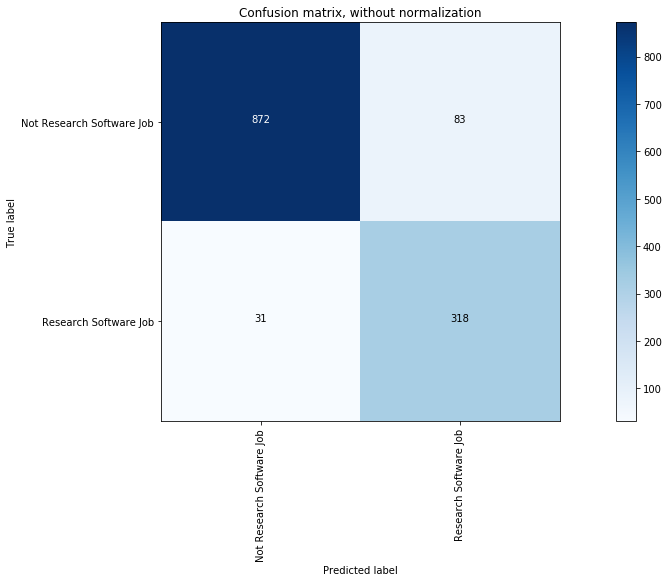

Normalized confusion matrix
[[0.91 0.09]
 [0.09 0.91]]


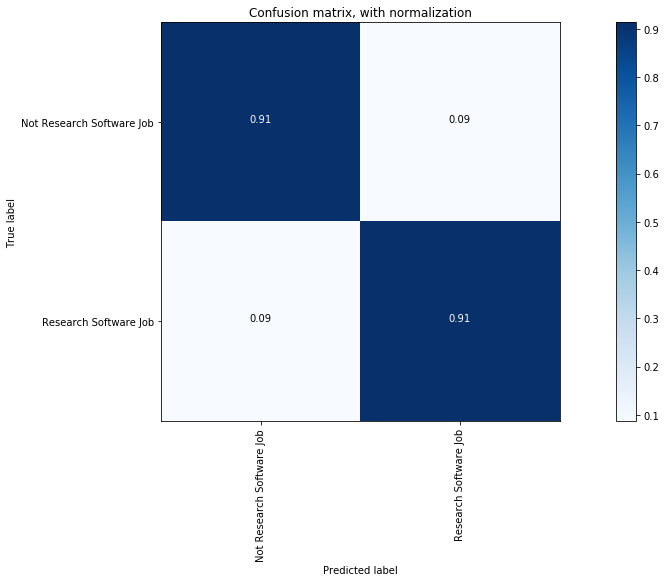

In [16]:
plt.figure(figsize=(16, 8))
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization', normalize=False)
plt.show();

plt.figure(figsize=(16, 8))
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, with normalization', normalize=True)
plt.show();
#plt.savefig('../outputs/dataPrediction/confusion_matrix_normalised.png', dpi=300, bbox_inches='tight')

## Scatter plot

In [17]:
def color_right(x, y):
    col = list()
    for i, j in zip(x, y):
        if i < 0.5 and j < 0.5:
            col.append('g')
        elif i > 0.5 and j > 0.5:
            col.append('g')
        elif i < 0.5 and j > 0.5:
            col.append('r')
        elif i > 0.5 and j < 0.5:
            col.append('r')
        else:
            col.append('grey')
    return col

In [18]:
def color_category(category):
    col = list()
    for cat in category:
        if cat == 'Insufficient Evidence':
            col.append('grey')
        elif cat == 0:
            col.append('red')
        elif cat == 1:
            col.append('green')
        elif cat == 'Ambiguous':
            col.append('grey')
    return col

In [19]:
def color_right(category):
    col = list()
    for cat in category:
        if cat is True:
            col.append('green')
        elif cat is False:
            col.append('red')
        elif cat == 'Ambiguous':
            col.append('gold')
        elif cat == 'Insufficient Evidence':
            col.append('grey')
        else:
            col.append('lightblue')
    return col

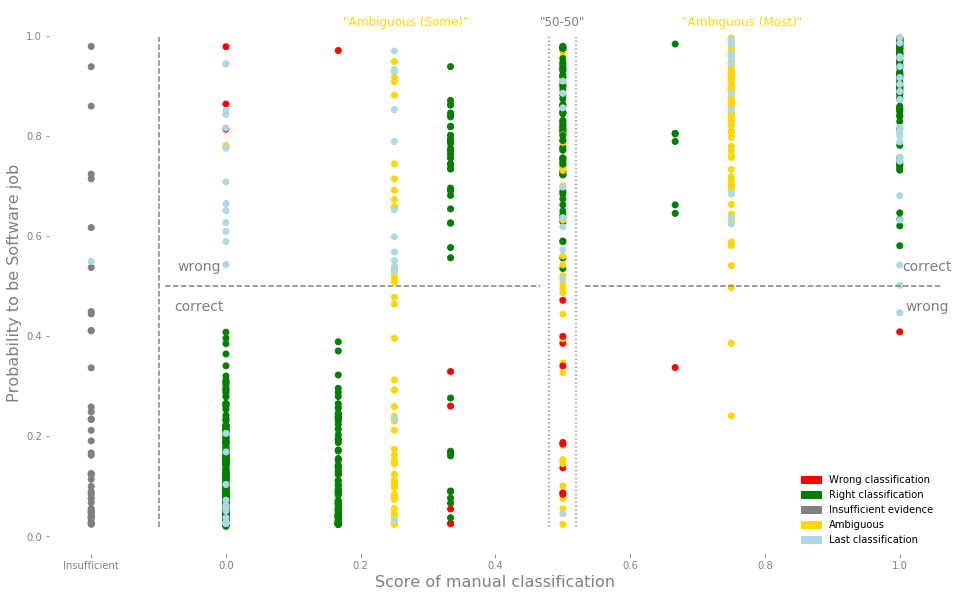

In [20]:
# Get a scatter plot to see the relation between the agg_tag score and the prediction proba to see where the model failed
# It seems to performing relatively according to expectation. There is a confusing point when aggregate score == 1
# and when the aggregate score is between 0.5 and 0.75 where it appears to classify it as in the opposite direction
# These score seems to represent ambiguious score where people have opposite views on the jobs ads. 

tag_creat = [abs(x) if abs(x) < 10 else x/50 for x in df['agg_tag'] ]
#pred_inv = [x for x in  df[df['agg_tag'] > -10]['prediction_proba']]
pred_inv = [x for x in  df['prediction_proba']]

new_tags =   [x for x in df['new_tags']]
color_tags = [x for x in df['corresponding_prev_train']]
#tag_creat = [x for x in df['agg_tag']]
#pred_inv = [x for x in  df['prediction_proba']]

col = color_right(color_tags)

fig, ax = plt.subplots(figsize=(16, 10))

plt.axhline(y=0.5, xmin=0.13, xmax=0.55, color='grey', linestyle='--')
plt.axvline(x=0.48, ymin=0.05, ymax=0.95, color='grey', linestyle=':')

plt.axhline(y=0.5, xmin=0.60, color='grey', linestyle='--')
plt.axvline(x=0.52,ymin=0.05, ymax=0.95, color='grey', linestyle=':')

#plt.axhline(y=0.5, color='grey', linestyle='--')

plt.axvline(x=-0.1, ymin=0.05, ymax=0.95, color='grey', linestyle='--')


#plt.axvline(x=0.230, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
#plt.axvline(x=0.27,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.2666,1.02,'"Ambiguous (Some)"', color='gold', fontsize=12, horizontalalignment='center')


#plt.axvline(x=0.730, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
#plt.axvline(x=0.77,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.7666,1.02,'"Ambiguous (Most)"', color='gold', fontsize=12, horizontalalignment='center')

#plt.axvline(x=0.02, ymin=0.05, ymax=0.95, color='lightblue', linestyle=':')
#plt.axvline(x=-0.02,ymin=0.05, ymax=0.95, color='lightblue', linestyle=':')
#plt.text(0.0,1.02,'"Insufficient"', color='lightblue', fontsize=12, horizontalalignment='center')


plt.text(0.5,1.02,'"50-50"', color='grey', fontsize=12, horizontalalignment='center')

plt.text(1.04,0.53,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(-0.04,0.45,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(1.04,0.45,'wrong', color='grey', fontsize=14, horizontalalignment='center')
plt.text(-0.04,0.53,'wrong', color='grey', fontsize=14, horizontalalignment='center')

ax.set_ylabel('Probability to be Software job', fontsize=16, color='grey')
ax.tick_params(axis='y', colors='grey')

ax.set_xlabel('Score of manual classification', fontsize=16, color='grey')
ax.tick_params(axis='x', colors='grey')
#plt.scatter(tag_creat, pred_inv, color=col)
plt.scatter(tag_creat, pred_inv, color=col)
wrong = mpatches.Patch(color='red', label='Wrong classification')
right = mpatches.Patch(color='green', label='Right classification')
insuff = mpatches.Patch(color='grey', label='Insufficient evidence')
amb = mpatches.Patch(color='gold', label='Ambiguous')
third = mpatches.Patch(color='lightblue', label='Last classification')

plt.legend(handles=[wrong, right, insuff, amb, third], frameon=False)

xlabels = [round(x, 1) if x != -0.2 else 'Insufficient' for x in ax.get_xticks().tolist()]
ax.set_xticklabels(xlabels)
for d in ["left", "top", "bottom", "right"]:
    plt.gca().spines[d].set_visible(False)


## Details on each problematic classifications

 ### 'Some' classification

In [21]:
df[(df['agg_tag'] > 0.25) & (df['agg_tag'] < 0.4)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,previous_tags,new_tags,agg_created_tag,prediction,prediction_proba
11,AJB093,first_run,No,Most,No,0.333333,0,No,0,0,0.076061
15,AJB524,first_run,No,No,Most,0.333333,0,No,0,0,0.089085
24,AJC363,first_run,Some,No,Some,0.333333,1,Some,0,1,0.801198
67,AJJ269,first_run,No,No,Most,0.333333,0,No,0,0,0.025219
69,AJJ541,first_run,Some,Some,No,0.333333,1,Some,0,1,0.774545
71,AJJ630,first_run,Some,No,Some,0.333333,1,Some,0,1,0.784730
118,AJR085,first_run,Some,No,Some,0.333333,1,Some,0,1,0.841471
121,AJR391,first_run,Some,No,Some,0.333333,1,Some,0,1,0.625704
162,AJZ805,first_run,Some,Some,No,0.333333,1,Some,0,1,0.733993
171,AKA464,first_run,Some,No,Some,0.333333,1,Some,0,1,0.742850


### '50-50' category

In [22]:
df[(abs(df['agg_tag']) ==0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,previous_tags,new_tags,agg_created_tag,prediction,prediction_proba
3,AIZ429,first_run,Some,Some,None,0.5,1,Some,1,1,0.930705
20,AJB834,first_run,No,Insufficient Evidence,Most,-0.5,Ambiguous,Some,1,0,0.495131
33,AJE034,first_run,Some,Some,None,0.5,1,Some,1,1,0.932115
38,AJE987,first_run,No,Insufficient Evidence,Most,-0.5,Ambiguous,Some,1,0,0.150855
39,AJF111,first_run,Some,Some,None,0.5,1,Some,1,1,0.931772
44,AJF652,first_run,Some,Some,None,0.5,1,Some,1,1,0.588299
48,AJH016,first_run,No,Most,Insufficient Evidence,-0.5,Ambiguous,Some,1,0,0.393727
59,AJI375,first_run,Some,Some,None,0.5,1,Some,1,1,0.751355
62,AJI549,first_run,Some,Some,None,0.5,1,Some,1,1,0.820808
65,AJJ046,first_run,Insufficient Evidence,Some,Some,-0.5,1,Some,1,1,0.803341


### insufficient evidence

In [23]:
df[(df['agg_tag'] == 0)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,previous_tags,new_tags,agg_created_tag,prediction,prediction_proba
0,AIT723,first_run,No,No,None,0.0,0,No,0,0,0.042342
1,AIY398,first_run,No,No,None,0.0,0,No,0,0,0.025219
2,AIZ101,first_run,No,No,None,0.0,0,No,0,0,0.177707
5,AIZ699,first_run,No,No,None,0.0,0,No,0,0,0.036681
6,AIZ815,first_run,No,No,None,0.0,0,No,0,0,0.029165
8,AJA135,first_run,No,No,None,0.0,0,No,0,0,0.025219
9,AJA422,first_run,No,No,None,0.0,0,No,0,0,0.116838
10,AJA612,first_run,No,No,None,0.0,0,No,0,0,0.023505
12,AJB201,first_run,No,Insufficient Evidence,No,-0.0,0,No,0,0,0.025219
13,AJB310,first_run,No,No,None,0.0,0,No,0,0,0.025219


### Wrongly classified jobs

#### Description of the wrongly classify as Software job

In [24]:
df[(abs(df['agg_tag']) < 0.33) &(df['prediction_proba'] > 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,previous_tags,new_tags,agg_created_tag,prediction,prediction_proba
105,AJO760,first_run,Some,No,Insufficient Evidence,-0.250000,Ambiguous,No,0,1,0.655639
179,AKB794,first_run,No,Some,Insufficient Evidence,-0.250000,Ambiguous,No,0,1,0.534018
397,ALN210,first_run,Some,Insufficient Evidence,No,-0.250000,Ambiguous,No,0,1,0.743739
420,ALR295,first_run,Some,No,Insufficient Evidence,-0.250000,Ambiguous,No,0,1,0.917666
426,ALS409,first_run,Some,Insufficient Evidence,No,-0.250000,Ambiguous,No,0,1,0.908283
432,ALT703,first_run,No,Insufficient Evidence,Some,-0.250000,Ambiguous,No,0,1,0.507458
493,AMF348,first_run,Insufficient Evidence,Some,No,-0.250000,Ambiguous,No,0,1,0.659003
568,AMQ686,first_run,Insufficient Evidence,No,Some,-0.250000,Ambiguous,No,0,1,0.527544
582,AMT536,first_run,Insufficient Evidence,No,Some,-0.250000,Ambiguous,No,0,1,0.948265
652,AND726,first_run,No,No,None,0.000000,0,No,0,1,0.863378


In [25]:
wrong_soft = df[(abs(df['agg_tag']) < 0.33) &(df['prediction_proba'] > 0.5)]['job_title']
for i, txt in enumerate(wrong_soft):
    i+=1
    print('{}: {}'.format(i, txt))

1: Research Associate
2: Research Assistant
3: Research Associate in Health Psychology or Epidemiology
4: Chair in Aerospace Engineering
5: Research Associate
6: Research Associate in Nuclear Graphite
7: Hydralab-PLUS Post-Doctoral Researcher
8: Organisation & People Data Manager
9: Lecturer (Entry Level) in Graphic Design
10: Research Fellow – Project “Sub-national Context and Radical right support in Europe” (SCoRE)
11: Electronic Development Engineer
12: Research Associate
13: Clinical Research IT Services Team Leader
14: Information Services and Technology Officer
15: Research Fellow
16: PhD Studentship in Mechanical Engineering and Systems Engineering - Enhanced Respiratory Protection Technology
17: Postdoctoral Statistician
18: Lecturer/Senior Lecturer/Reader or Chair in Big Data Science and Technology
19: Research Fellow
20: PhD Studentship: Thermo-Mechanical Property Measurement of Nuclear Graphites at Elevated Temperatures
21: Lecturer in Experimental Quantum Spintronics
22: S

#### Description of the wrongly classify as NOT Software job

In [26]:
df[(abs(df['agg_tag']) > 0.5) & (abs(df['agg_tag']) < 10) &(df['prediction_proba'] < 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,previous_tags,new_tags,agg_created_tag,prediction,prediction_proba
58,AJH869,first_run,Most,Most,No,0.666667,1,Most,1,0,0.336756
80,AJL914,first_run,Most,Insufficient Evidence,Most,-1.000000,1,Most,1,0,0.408043
319,ALA126,first_run,Some,Most,None,0.750000,Ambiguous,Some,1,0,0.385134
471,AMB006,first_run,Some,Most,None,0.750000,Ambiguous,Some,1,0,0.496890
700,ANM607,first_run,Some,Most,None,0.750000,Ambiguous,Some,1,0,0.240489
1362,BGS024,third_run,Most,Most,None,1.000000,third_run,Most,1,0,0.446320


In [27]:
wrong_not = df[(abs(df['agg_tag']) > 0.5) & (abs(df['agg_tag']) < 10) &(df['prediction_proba'] < 0.5)]['job_title']
for i, txt in enumerate(wrong_not):
    i+=1
    print('{}: {}'.format(i, txt))

1: Professor of Computer Science and Digital Technologies
2: Senior Research Assistant
3: Research Lecturer - Machine Learning
4: Research Associate in 2D Nanomaterial Production and Applications
5: NIHR Research Methods Fellowship in Health Economics (Research Assistant)
6: Post-Doctoral Research Assistant


### Strongly classified as Software job while being 'Some'

In [28]:
#df[(abs(df['agg_tag']) == 0.5) & (df['prediction_proba'] > 0.9)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'previous_tags', 'new_tags', 'agg_created_tag', 'prediction', 'prediction_proba', ]]

In [29]:
wrong_some = df[(abs(df['agg_tag']) == 0.5) & (df['prediction_proba'] > 0.9)]['job_title']
for i, txt in enumerate(wrong_some):
    i+=1
    print('{}: {}'.format(i, txt))

1: Senior Systems Administrator
2: Postdoctoral Research Assistant in Experimental Quantum Device Physics
3: Research Associate in Development and Application of Novel Reservoir Modelling Methods
4: Research Associate in Complex Interfacial Flows
5: Research Associate (Statistician)
6: Senior Postdoctoral Research Fellow
7: Subject Leader in Creative Computing
8: Postdoctoral Research Associate
9: Research Assistant – The Ontogeny of Bone Composition & Microstructure as a model of Programmed Transformation in smart Materials
10: Associate Research Fellow
11: Postdoctoral Research Assistant in Biological Physics
12: Post-Doctoral Research Assistant
13: Postdoctoral Researcher in the Economic Analysis of Technological Change Needed for a Transition to Sustainable Energy
14: Senior Research Associate
15: Post-Doctoral Research Associate: Monitoring Urban Atmospheric Pollution
16: PhD Studentship Available to start September 2015: Synthetic aperture interferometry: High-resolution optical 

## Features

### Adding 'research software' boolean

In [30]:
cleaner = textClean(remove_stop=True)

In [31]:
df = features.check_if_research_software(df, cleaner)

In [32]:
df['research_software'].value_counts()

0    1303
1       1
Name: research_software, dtype: int64

### Prepare labels

In [37]:
y = features.prepare_labels(df, column='previous_tags')


TypeError: 'int' object is not iterable

In [36]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [34]:
df.to_csv('./data/training_set/training_set.csv')